### Load the Data

upload a data set with file structure 

data/positive and data/negative

then add empty data/spec/positive and
data/spec/negative directories

In [1]:
import os
if "data" in os.listdir():
  os.system("rm -rf data")

In [3]:
# Used to unzip a data set loaded to the drive
import zipfile

with zipfile.ZipFile("solo.zip") as z:
  z.extractall()

### Data Preprocessing Pipeline

In [4]:
import os

from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt

def convert_audio_to_spectogram(filename, outfilename=None, overwrite=False):
    """
    convert_audio_to_spectogram -- using librosa to plot and save a spectrogram
    
    Arguments:
    filename -- filepath to the file that you want to see the waveplot for
    outfilename -- filepath to the output spectrogram (must be something matplotlib.pyplot.savefig() can handle)
    overwrite -- whether to overwrite if a file already exists with the given outfilename
    
    Returns -- None
    """
    
    # sr == sampling rate 
    audio_data, sr = librosa.load(filename, sr=44100)

    vertical_res = 4096
    
    # stft is short time fourier transform
    sgram = librosa.stft(audio_data, center=False, n_fft=vertical_res, win_length=vertical_res)
    
    # convert the slices to amplitude
    sgram_db = librosa.amplitude_to_db(abs(sgram))

    _, ax = plt.subplots(figsize=(5, 5))

    librosa.display.specshow(sgram_db, sr=sr, x_axis='time', y_axis='log', ax=ax, cmap='gray')

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                hspace = 0, wspace = 0)
    plt.margins(0,0)

    if outfilename in os.listdir() and not overwrite:
        print("Given filename already exists, to overwrite pass in argument `overwrite=True`")
        return
    if outfilename is not None:
        plt.savefig(outfilename)

        # crop the image to get rid of useless high and low frequencies
        im = Image.open(outfilename)
        im_cropped = im.crop((0, 90, 360, 315))
        im_cropped.save(outfilename)
    
    plt.close() # dont display the spectrogram on screen

In [ ]:
for item in os.listdir("./solo/positives"):
    convert_audio_to_spectogram("./solo/positives/"+item, f"./spec/positives/{item.rsplit('.', 1)[0]}.png")

for item in os.listdir("./solo/negatives"):
    convert_audio_to_spectogram(f"./solo/negatives/{item}", f"./spec/negatives/{item.rsplit('.', 1)[0]}.png")

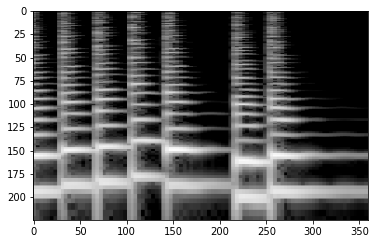

In [8]:
import matplotlib.image as mpimg
img = mpimg.imread('spec/positives/lick_0000.png')
plt.imshow(img)
plt.show()

### Build the model

In [9]:
import tensorflow as tf

In [10]:
# Load dataset from directory with keras

# sometimes a directory called .ipynb_checkpoints is present, remove it if so
if os.path.isdir('./data/.ipynb_checkpoints'):
  os.removedirs("./data/.ipynb_checkpoints")

train_directory = './data/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(360,225), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 656 files belonging to 2 classes.
Using 131 files for validation.
['negatives', 'positives']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


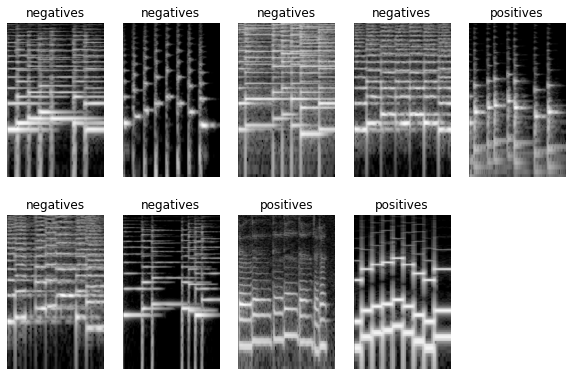

In [11]:
# Straight from the microsoft tutorial 
# shows the spectrograms with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model

In [23]:
# This came from the tutorial


# Define the model

num_classes = 2
img_height = 225
img_width = 360

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3)),

  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [24]:
learning_rate = 0.1

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 360, 225, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 360, 225, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 180, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 90, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 56, 64)       

In [26]:
# Set the epochs
epochs = 15
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, epochs=epochs, batch_size=1)


Fitting:
Epoch 1/15
5/5 [==============================] - 1s 96ms/step - loss: 0.6867 - accuracy: 0.5115
Epoch 2/15
5/5 [==============================] - 1s 96ms/step - loss: 0.6822 - accuracy: 0.5115
Epoch 3/15
5/5 [==============================] - 1s 94ms/step - loss: 0.6896 - accuracy: 0.5954
Epoch 4/15
5/5 [==============================] - 1s 96ms/step - loss: 0.6640 - accuracy: 0.7405
Epoch 5/15
5/5 [==============================] - 1s 96ms/step - loss: 0.7051 - accuracy: 0.5573
Epoch 6/15
5/5 [==============================] - 1s 96ms/step - loss: 0.6031 - accuracy: 0.7939
Epoch 7/15
5/5 [==============================] - 1s 98ms/step - loss: 0.7448 - accuracy: 0.5496
Epoch 8/15
5/5 [==============================] - 1s 97ms/step - loss: 0.6585 - accuracy: 0.7328
Epoch 9/15
5/5 [==============================] - 1s 96ms/step - loss: 0.6046 - accuracy: 0.6870
Epoch 10/15
5/5 [==============================] - 1s 95ms/step - loss: 0.7324 - accuracy: 0.5878
Epoch 11/15
5/5 [==

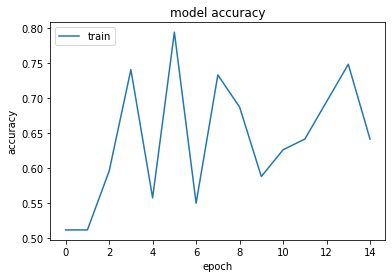

In [27]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()